In [12]:
# Numerical analysis
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(1)

In [13]:
# Parameters
n_realizations = 5
n = 400 # number of observations, length of beta_star 
D = n 
p_star = 20 # number of non-zero predictors
sigma = 1 # noise parameter

<h1> Generating Data </h1>

$$y_i \sim \beta_i + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma^2), \;\; i = 1, ..., 400$$
Similarly to Piironen's toy example, We generate $100$ data realizations. Our true parameter vector $\beta^*$ has length $D=400$ and $p^*=20$ non-zero entries with some value $A \in$ $\{1, 2, ..., 10\}$. The total number of observations per realization is $n=400$.

In [14]:
def generate_data(dim, pstar, A, sigma, nrep):
  """
  Generate synthetic data.

  Parameters:
    int dim: The dimension of the dataset
    int pstar: The number of true non-zero signals
    real A: The magnitude of true non-zero signals
    real sigma: Standard deviation of the noise
    nrep: The number of replications
  """
  data = np.zeros((nrep, dim))       # Initialise
  data[:, :pstar] += A               # Add signal
  data += np.random.normal(0, sigma, size=(nrep, dim))  # Add noise
  return data

<h2> Defining the Model </h2>

$$\begin{align*} 
\gamma_i &= \sigma (L_i + \log(\alpha_i) / \lambda) \text{  for   } i = 1, ..., n \\
L_i &= \log (U_i) - \log (1-U_i)\\
U_i &\sim \text{Uniform}(0, 1)
\end{align*}$$




In order for the model to work correctly, $\alpha_i$ must be  $\in (0, \infty)$. Some choices for $\alpha_i$ could be $\sigma(y)$, $\exp (y)$, etc.


In addition, the shrinkage coefficient $\kappa_i = 1 - \gamma_i$ is recorded.

In [15]:
def model(lam, sigma=1, y=None):
    '''
    Defines the Concrete random variable distribution.

    Parameters:
       real lam: temperature coefficient
       real sigma: stdev of y
       array y: dependent variable
    '''
    D = y.shape
    alphas = numpyro.deterministic("alphas", jnp.exp(y))
    U = numpyro.sample("U", dist.Uniform(0, 1).expand(D))
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1-U))
    gammas = numpyro.deterministic("gammas", sigmoid(L + jnp.log(alphas) / lam))
    kappas = numpyro.deterministic("kappas", 1-gammas)

In [16]:
def run_mcmc(model, prng_key, y, **kwargs):
    '''
    Run MCMC using the given model.

    Parameters:
       model: probabilistic model
       prng_key: random key 
       array y: observed data

    '''
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=500, num_samples=1000)
    mcmc.run(prng_key, y=y, **kwargs)
    return mcmc

In [17]:
def concrete(all_data, nrep, dim, pstar, lam):
    beta_samples = {}
    kappa_samples = []
    mean_sq_errors = [0]*11

    for A, y in all_data.items():
        beta_star = np.zeros(dim) 
        beta_star[:pstar] = beta_star[:pstar] + A
        mcmc = run_mcmc(model, prng_key, y, lam = lam)
        samples = mcmc.get_samples()
        mean_gammas = samples['gammas'].mean(axis=0) # mean across all samples in one mcmc run
        mean_gammas = mean_gammas.mean(axis=0) # mean across all repetitions
        estimated_betas = mean_gammas * beta_star
        mean_sq_errors[A] = jnp.mean((estimated_betas - beta_star)**2)
        beta_samples[A] = estimated_betas 
        kappa_samples.extend(samples['kappas'])
    
    return mean_sq_errors, kappa_samples, beta_samples

<h1> Run and Evaluate MCMC </h1>

In [18]:
all_mse_values = dict()
mean_mse_values = dict()
all_kappas = dict()
mean_betas = dict()

all_data = {}
A_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
smaller_A_values = [4, 6]
for A in A_values:
    all_data[A] = generate_data(dim=D, pstar=p_star, A=A, sigma=1, nrep=n_realizations) 

lams = [2, 1, 1/2, 1/10, 1/100, 1/10000]

for lam in lams:

    mean_sq_errors, kappas, mean_betas_lam = concrete(all_data, 
                                                nrep=n_realizations, 
                                                dim=D, 
                                                pstar=p_star,
                                                lam=lam)
    all_mse_values[lam] = []
    all_mse_values[lam].append(mean_sq_errors)
    all_kappas[lam] = []
    all_kappas[lam].extend(kappas)

    all_mse_values[lam] = np.array(all_mse_values[lam])
    mean_mse_values[lam] = np.mean(all_mse_values[lam], axis=0)

    mean_betas[lam] = mean_betas_lam


sample: 100%|██████████| 1500/1500 [00:02<00:00, 590.95it/s, 31 steps of size 1.88e-01. acc. prob=0.86]


The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [19]:
# for mcmc in all_mcmc_runs[:5]:
#     print(az.ess(mcmc))
#     print(az.rhat(mcmc))

<h1> Results </h1>

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_63691/4065309188.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


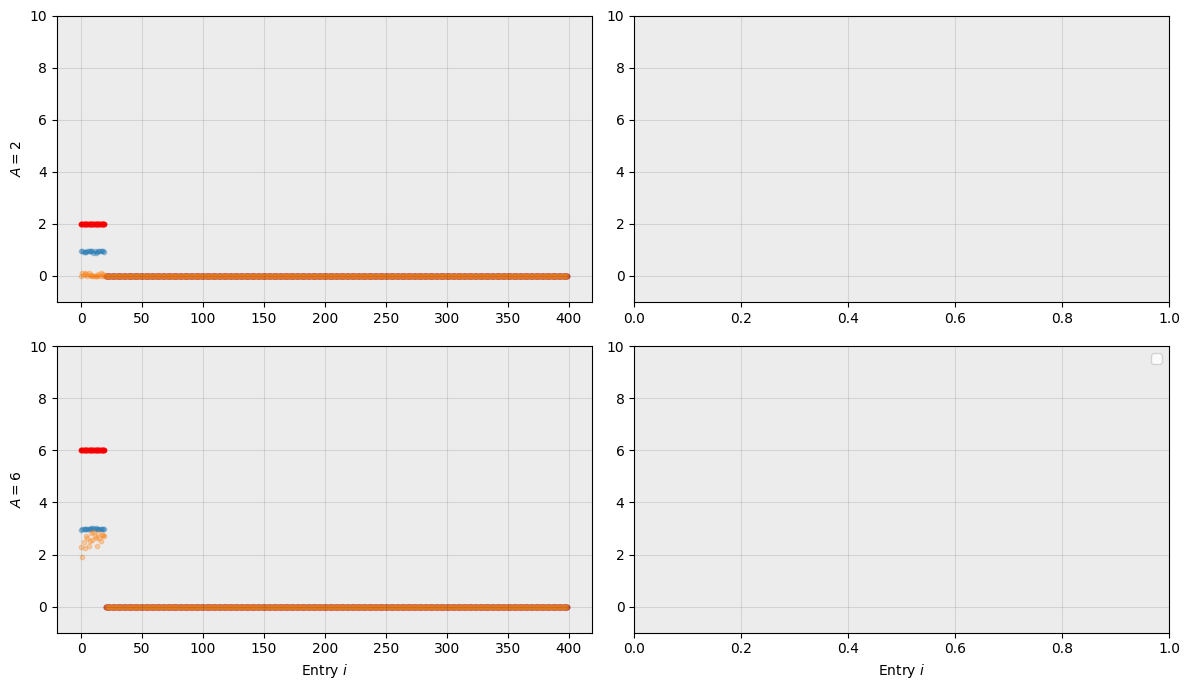

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7), layout="tight")
for ax in [ax1, ax2, ax3, ax4]: 
    ax.set_facecolor("#ECECEC") # set graph background color to grey
    ax.grid(visible=True, color="black", alpha=0.1) # add grid lines

# resetting y-axis range so that the graphs line up
ax2.set_ylim([-1, 10]) 
ax1.set_ylim([-1, 10])
ax4.set_ylim([-1, 10]) 
ax3.set_ylim([-1, 10])


beta_star_4 = np.zeros(n)
beta_star_4[:p_star] = 4
beta_star_6 = np.zeros(n)
beta_star_6[:p_star] = 6
beta_star_2 = np.zeros(n)
beta_star_2[:p_star] = 2
beta_star_8 = np.zeros(n)
beta_star_8[:p_star] = 8

ax1.scatter(range(D), beta_star_2, color='red', s=10) # plot actual betas
ax3.scatter(range(D), beta_star_6, color='red', s=10) 
for lam in [1, 1/100]:
    ax1.scatter(range(D), mean_betas[lam][2], s=10, alpha=0.3)
    ax3.scatter(range(D), mean_betas[lam][6], s=10, alpha=0.3)


# add labels to graph
ax1.set(ylabel=r'$A=2$')
ax3.set(ylabel=r'$A=6$', xlabel=r'Entry $i$')
ax4.set(xlabel=r'Entry $i$')
plt.legend()


As $\lambda$ decreases, mean squared error decreases.

Text(0.5, 1.0, 'Mean Squared Error for Different Lambda Values')

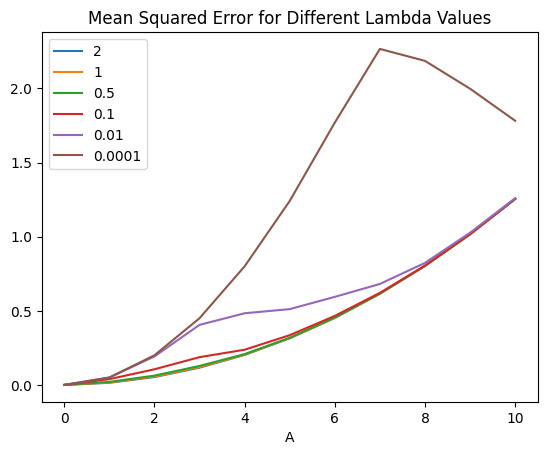

In [21]:
for lam in lams:
    plt.plot(range(len(mean_mse_values[lam])), mean_mse_values[lam], label=f'{lam}')
ax = plt.gca()
plt.legend()
plt.xlabel("A")
plt.title("Mean Squared Error for Different Lambda Values")

As the value of $\lambda$ decreases, the distribution of $\kappa$ values becomes more concentrated around $0$ and $1$.

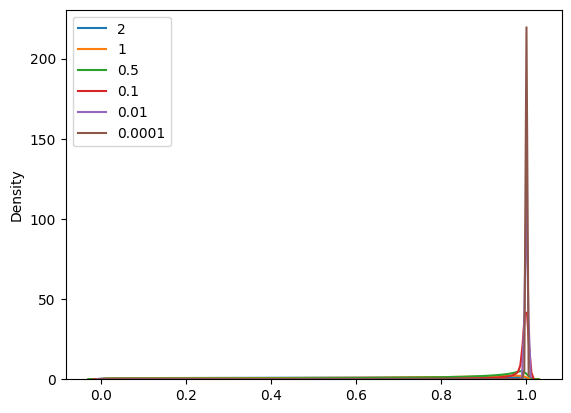

In [22]:
for lam in lams:
    all_kappas[lam] = np.ndarray.flatten(np.array(all_kappas[lam]))
    sns.kdeplot(all_kappas[lam], label=f'{lam}')
plt.legend()